# Uncertainty Results
In this Notebook we show the results on the LEO sulphamides dataset for VI, Langevin, Ensembling.
The Langevin and Ensembling results are loaded from samples collected in other notebooks (see training notebooks). 
The Variational results are sampled here, so the sampling based results will vary (increase number of samples to reduce this variation).

In [432]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from os import path
import copy

from chemprop.features import BatchMolGraph, MolGraph
from chemprop.data.data import MoleculeDatapoint, MoleculeDataset
from chemprop.data import MoleculeDataLoader, split_data
import torch
td = torch.distributions
from chemprop.args import TrainArgs, HyperoptArgs
from tqdm import tqdm
from chemprop.models.model import BayesianMoleculeModel
from chemprop.features.featurization import BatchMolGraph
from chemprop.data import get_data

In [433]:
def plot_coverage(y_pred_s, target_ind, title):
    pred_ints = np.linspace(0, 1, 100)[1:]
    y_test = np.array(target_batch)
    icp = []
    for pred_int in pred_ints:
        p_upper = 1 - (1-pred_int)/2
        p_lower = p_upper - pred_int
        q1 = np.quantile(y_pred_s, p_lower, axis=0)
        q2 = np.quantile(y_pred_s, p_upper, axis=0)

        icp.append(np.mean(np.logical_and(y_test[:,target_ind].squeeze() < q2, y_test[:,target_ind].squeeze() > q1)))
    
    x_perf = np.linspace(0, 1, 1000)
    plt.plot(x_perf, x_perf)
    plt.plot(icp, pred_ints)
    plt.xlabel('Estimated Interval Coverage')
    plt.ylabel('Prediction Interval')
    plt.axis('equal')
    plt.title(title)
    plt.show()

In [434]:
def error_calibration(y_pred, y_std, targ_index, title):
    sort_index = np.argsort(y_std)
    y_test_ = y_test[sort_index]
    y_pred_ = y_pred[sort_index]
    y_std_ = y_std[sort_index]
    y_test_ = y_test[:-1]
    y_pred_ = y_pred[:-1]
    y_std_ = y_std[:-1]
    aggregate_every = 6
    rmse = np.empty((len(test_data) // aggregate_every))
    sigma = np.empty((len(test_data) // aggregate_every))

    for i in range(len(test_data) // aggregate_every):
        y_test_agr = y_test_[i*aggregate_every:(i+1)*aggregate_every, targ_index]
        y_pred_agr = y_pred_[i*aggregate_every:(i+1)*aggregate_every]
        y_std_agr  = y_std_[i*aggregate_every:(i+1)*aggregate_every]

        sigma[i] = np.mean(y_std_agr)
        rmse[i] = np.sqrt(np.mean((y_pred_agr - y_test_agr)**2))
    ence = ENCE(sigma, rmse)
    return sigma, rmse, ence

In [435]:
def ENCE(sigma, rmse):
    return np.mean(np.abs(sigma - rmse) / sigma)

In [436]:
class BayesianArgs(TrainArgs):
    sigma1 = torch.tensor(1)
    sigma2 = torch.tensor(np.exp(-6.0))
    prior = td.Normal(0,1)
    data_path = "data/leo_sulphamides_JAKs.csv"
    init = 'zeros' 
    init_lr = 1e-5
    max_lr = 1e-3
    final_lr = 1e-4
    split_sizes = (0.8, 0.1, 0.1)
    epochs = 5000
    warmup_epochs = 10

args = BayesianArgs()
if args.data_path == "data/leo_sulphamides_JAKs.csv":
    args.num_tasks = 3
else:
    args.num_tasks = 1
args.ffn_hidden_size = 100
args.hidden_size = 100
args.ffn_num_layers = 2
args.depth = 6
args.dropout = 0.0 # Changed from 0.15
args.num_workers = 0
args.batch_size = 50 #200 # Changed from 50
args.dataset_type = 'regression'

/work3/s164180/anaconda3/envs/chemprop/lib/python3.8/site-packages/tap/tap.py:304: UserWarning: add_arguments is deprecated and will be removed on January 1st, 2021 please override "configure" instead and call add_argument there. 
  warn('add_arguments is deprecated and will be removed on January 1st, 2021'


In [437]:
load_trained = True
device = torch.device('cuda')
mod = BayesianMoleculeModel(args, device=device)

mod.load_state_dict(torch.load("Checkpoints/leo_sulphamides_JAKs_hidden_100_ffn_num_2_depth_6_dropout_0.0_epochs_3000.pt"))


<All keys matched successfully>

In [438]:
data = get_data(path=args.data_path, args=args, skip_none_targets=True)
train_data, val_data, test_data = split_data(data=data, 
                                             split_type=args.split_type, 
                                             sizes=args.split_sizes, 
                                             seed=args.seed, 
                                             num_folds=args.num_folds, 
                                             args=args, 
                                             logger=None)

862it [00:00, 225798.78it/s]
100%|██████████| 862/862 [00:00<00:00, 2593.33it/s]


In [439]:
# Standardise train/val/test sets by training set's mean/std
targets_train_np = np.array(train_data.targets())
targets_val_np = np.array(val_data.targets())
targets_test_np = np.array(test_data.targets())
y_mean_train = np.mean(targets_train_np, axis=0)
y_std_train = np.std(targets_train_np, axis=0)
targets_train_np = (targets_train_np - y_mean_train)/y_std_train
targets_val_np = (targets_val_np - y_mean_train)/y_std_train
targets_test_np = (targets_test_np - y_mean_train)/y_std_train

train_data.set_targets(targets_train_np)
val_data.set_targets(targets_val_np)
test_data.set_targets(targets_test_np)
test_data_loader = MoleculeDataLoader(dataset=test_data,batch_size=len(test_data),num_workers=args.num_workers)

# Variational Inference

In [440]:
mod.eval()
mod.to(device)

S = 5000
mod.sampling_mode(True)
batch = next(iter(test_data_loader))
mol_batch, features_batch, target_batch, atom_descriptors_batch = \
            batch.batch_graph(), batch.features(), batch.targets(), batch.atom_descriptors()
y_test = np.array(target_batch)
y_mean = np.empty((S, len(test_data), args.num_tasks))
y_var = np.empty((S, len(test_data), args.num_tasks))
y_pred_s = np.empty((S, len(test_data), args.num_tasks))
for s in range(S):
    y_pred_mean, y_pred_rho = mod.forward(mol_batch[0])
    y_pred_std = mod.softplus(y_pred_rho) + mod.eps
    
    y_pred_var = (y_pred_std)**2
    y_var[s] = y_pred_var.cpu().detach().numpy()#[:, targ_index]
    y_mean[s] = y_pred_mean.cpu().detach().numpy()#[:, targ_index]
    y_pred_s[s] = td.Normal(y_pred_mean, y_pred_std).sample().cpu().detach().numpy()#[:,targ_index]

In [441]:
print("RMSE:", np.sqrt(np.mean((np.mean(y_pred_s, axis=0) - y_test.squeeze())**2)))

RMSE: 1.2027734128110423


In [442]:
mod.sampling_mode(False)
y_pred_mean, _ = mod.forward(mol_batch[0])
y_pred_mean = y_pred_mean.cpu().detach().numpy()
print("RMSE (non-sampling):", np.sqrt(np.mean((y_pred_mean - y_test.squeeze())**2)))

RMSE (non-sampling): 1.2027816000857043


In [443]:
y_pred = np.mean(y_mean, axis=0)
y_var_al = np.mean(y_var, axis=0)
y_std_al = np.sqrt(y_var_al)

y_var_epi = np.var(y_mean, axis=0)
y_std_epi = np.sqrt(y_var_epi)

y_var_total = y_var_al + y_var_epi
y_std_tot = np.sqrt(y_var_total)

y_std_sample = np.std(y_pred_s, axis=0)

0 Aleatoric ENCE:  0.766513217604503
0 Epistemic ENCE:  21.67905911892624
0 Total ENCE:  0.7638077968762361


<ipython-input-444-3a9702c4a678>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()
<ipython-input-444-3a9702c4a678>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


1 Aleatoric ENCE:  0.2853503099451917
1 Epistemic ENCE:  19.93088643134916
1 Total ENCE:  0.28559524751717996
2 Aleatoric ENCE:  7.207189717111777
2 Epistemic ENCE:  143.9437644272933
2 Total ENCE:  7.192273704645991


<ipython-input-444-3a9702c4a678>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


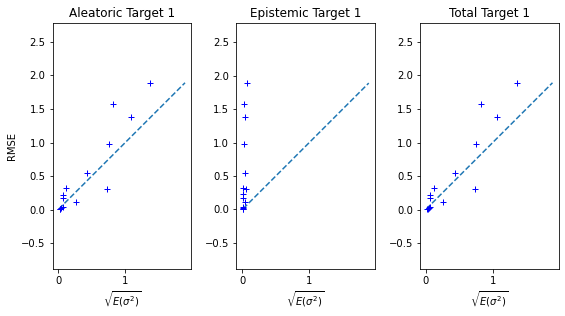

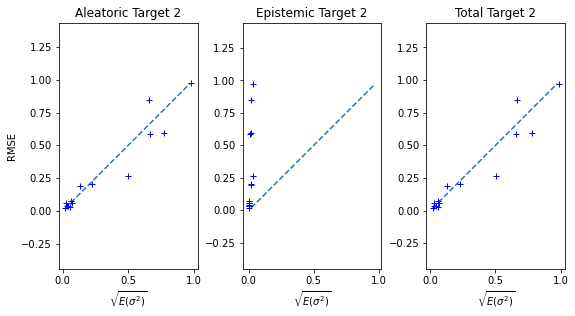

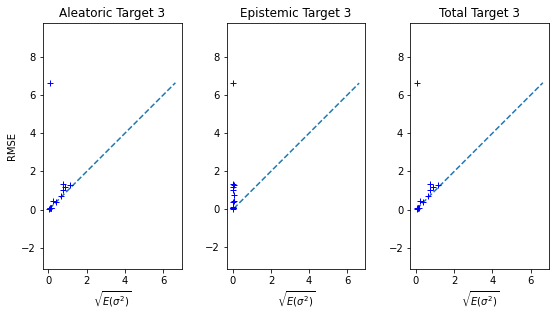

In [444]:
y_stds = [y_std_al, y_std_epi, y_std_sample]
titles = ['Aleatoric', 'Epistemic', 'Total']
alignments = [1.75, 1.75, 1.75]

for t in range(args.num_tasks):
    fig, axs = plt.subplots(1, 3, sharey=False, constrained_layout=True, figsize=(8,4))
    axs[0].set_ylabel('RMSE')
    fig.tight_layout()
    for i, (align, title, y_std) in enumerate(zip(alignments, titles, y_stds)):
        sigma, rmse, ence = error_calibration(y_pred[:,t], y_std[:,t], t, title='Aleatoric')
        x = np.linspace(np.min(rmse),np.max(rmse),100)
        y = x
        print(t, title, "ENCE: ", ence)
        axs[i].plot(x, y, '--')
        axs[i].plot(sigma, rmse, 'b+')
        axs[i].set_xlabel('$\sqrt{E(\sigma^2)}$')
        axs[i].set_ylim(np.min(rmse), np.max(rmse))
        axs[i].axis('equal')
        axs[i].set_title(title + f" Target {t+1}")

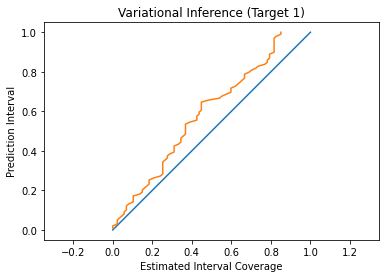

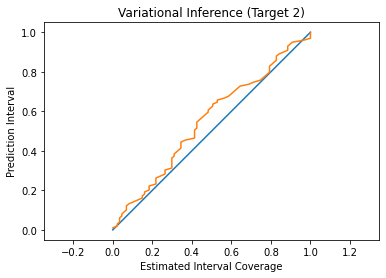

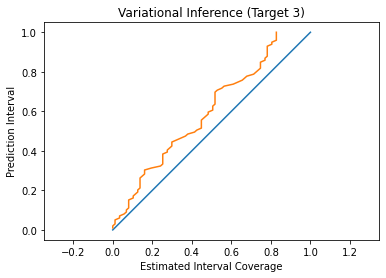

In [445]:
for t in range(args.num_tasks):
    plot_coverage(y_pred[:,t], t, title=f'Variational Inference (Target {t+1})')

In [446]:
y_pred_var = y_pred
y_std_var = y_stds

In [447]:
y_pred_var.shape

(87, 3)

# Langevin

In [464]:
# Langevin

langevin_means = []
langevin_std = []
langevin_test = []


for i in range(1,4):
    mean = np.loadtxt(f"Predictions/langevin_mean_JAK{i}.txt")
    std = np.loadtxt(f"Predictions/langevin_std_JAK{i}.txt")
    test = np.loadtxt(f"Predictions/langevin_test_JAK{i}.txt")
    
    langevin_means.append(mean)
    langevin_std.append(std)
    langevin_test.append(test)   
    

In [465]:
langevin_means = np.array(langevin_means)
langevin_std = np.array(langevin_std)
langevin_test = np.array(langevin_test)


y_pred = np.mean(langevin_means,axis=2)
y_std_al = np.mean(langevin_std, axis = 2)
y_var_epi = np.var(langevin_means, axis =2)
y_std_epi = np.sqrt(y_var_epi)


y_var_total = y_var_al.T + y_var_epi
y_std_tot = np.sqrt(y_var_total)

y_std_sample = np.std(langevin_means, axis = 2)



<ipython-input-466-39161a562680>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()
<ipython-input-466-39161a562680>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


0 Aleatoric ENCE:  1.463037610951835
0 Epistemic ENCE:  19.31472895909435
0 Total ENCE:  0.5916631888067545
1 Aleatoric ENCE:  0.3420995397792727
1 Epistemic ENCE:  10.22800515209863
1 Total ENCE:  0.6933603583469728


<ipython-input-466-39161a562680>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


2 Aleatoric ENCE:  6.625889098157126
2 Epistemic ENCE:  90.61056682873871
2 Total ENCE:  2.3380387088737105


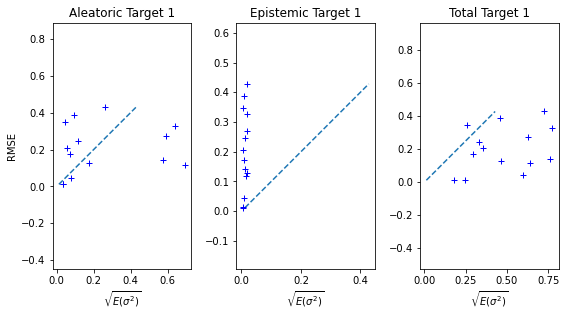

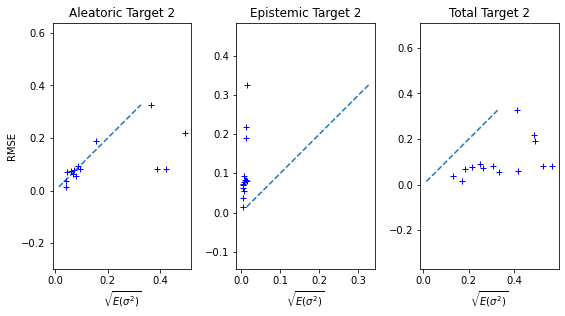

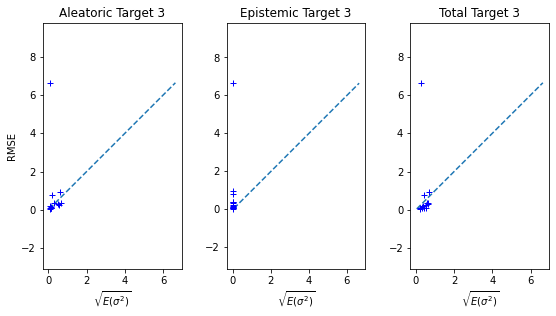

In [466]:
y_stds = [y_std_al, y_std_epi, y_std_tot]
titles = ['Aleatoric', 'Epistemic', 'Total']
alignments = [1.75, 1.75, 1.75]

for t in range(args.num_tasks):
    fig, axs = plt.subplots(1, 3, sharey=False, constrained_layout=True, figsize=(8,4))
    axs[0].set_ylabel('RMSE')
    fig.tight_layout()
    for i, (align, title, y_std) in enumerate(zip(alignments, titles, y_stds)):
        sigma, rmse, ence = error_calibration(y_pred[t,:], y_std[t,:], t, title='Aleatoric')
        x = np.linspace(np.min(rmse),np.max(rmse),100)
        y = x
        print(t, title, "ENCE: ", ence)
        axs[i].plot(x, y, '--')
        axs[i].plot(sigma, rmse, 'b+')
        axs[i].set_xlabel('$\sqrt{E(\sigma^2)}$')
        axs[i].set_ylim(np.min(rmse), np.max(rmse))
        axs[i].axis('equal')
        axs[i].set_title(title + f" Target {t+1}")

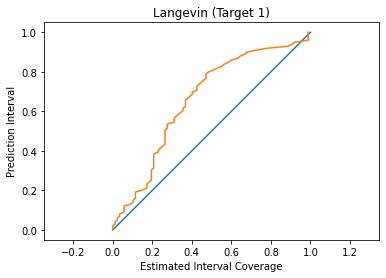

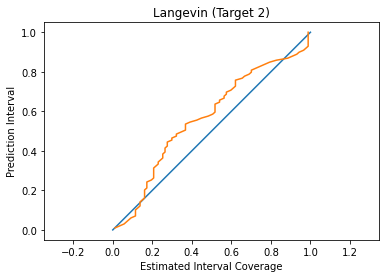

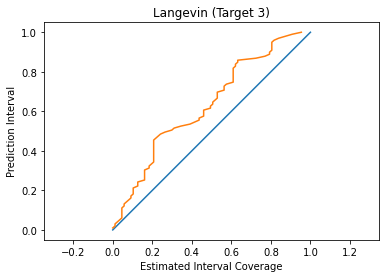

In [467]:
for t in range(args.num_tasks):
    plot_coverage(y_pred[t,:], t, title=f'Langevin (Target {t+1})')

In [452]:
y_pred_lv = y_pred
y_std_lv = y_stds

In [486]:
np.sqrt(np.mean((y_pred.T - y_test)**2))

1.0424818267619

# Ensemble

In [487]:
mean = np.load('Predictions/mean_hetero_leo.npy')
std = np.load('Predictions/std_hetero_leo.npy')

In [488]:
y_pred = np.mean(mean, axis = 0)
y_var_al = np.mean(std**2, axis=0)
y_std_al = np.sqrt(y_var_al)

y_var_epi = np.var(mean, axis=0)
y_std_epi = np.sqrt(y_var_epi)

y_var_total = y_var_al + y_var_epi
y_std_tot = np.sqrt(y_var_total)

y_std_sample = np.std(mean, axis=0)


In [489]:
y_pred.shape

(87, 3)

<ipython-input-490-b75ae9c44d10>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()
<ipython-input-490-b75ae9c44d10>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


0 Aleatoric ENCE:  0.5337613520316835
0 Epistemic ENCE:  0.8834017899660067
0 Total ENCE:  0.5472222244677295
1 Aleatoric ENCE:  0.656020492368298
1 Epistemic ENCE:  0.43232539763705635
1 Total ENCE:  0.6695134769884122


<ipython-input-490-b75ae9c44d10>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


2 Aleatoric ENCE:  2.289030847349164
2 Epistemic ENCE:  5.315816968474282
2 Total ENCE:  2.1299806979991875


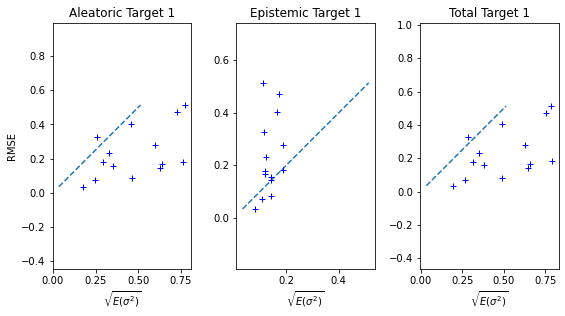

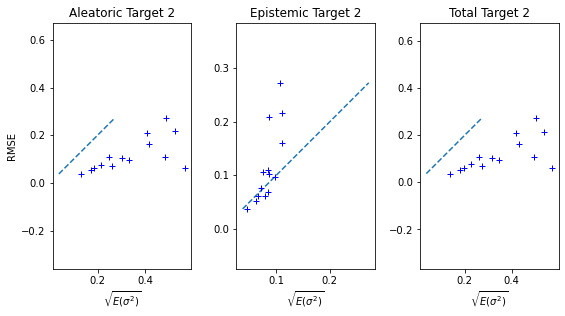

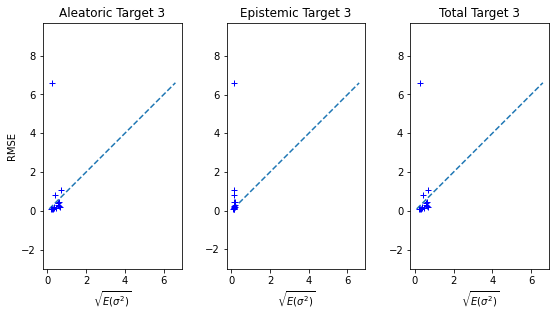

In [490]:
y_stds = [y_std_al, y_std_epi, y_std_tot]
titles = ['Aleatoric', 'Epistemic', 'Total']
alignments = [1.75, 1.75, 1.75]

for t in range(args.num_tasks):
    fig, axs = plt.subplots(1, 3, sharey=False, constrained_layout=True, figsize=(8,4))
    axs[0].set_ylabel('RMSE')
    fig.tight_layout()
    for i, (align, title, y_std) in enumerate(zip(alignments, titles, y_stds)):
        sigma, rmse, ence = error_calibration(y_pred[:,t], y_std[:,t], t, title='Aleatoric')
        x = np.linspace(np.min(rmse),np.max(rmse),100)
        y = x
        print(t, title, "ENCE: ", ence)
        axs[i].plot(x, y, '--')
        axs[i].plot(sigma, rmse, 'b+')
        axs[i].set_xlabel('$\sqrt{E(\sigma^2)}$')
        axs[i].set_ylim(np.min(rmse), np.max(rmse))
        axs[i].axis('equal')
        axs[i].set_title(title + f" Target {t+1}")

1.0437514454098147

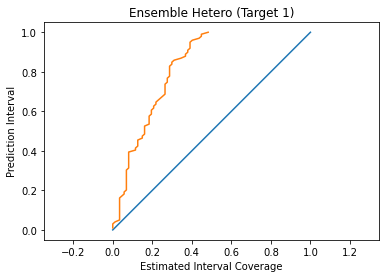

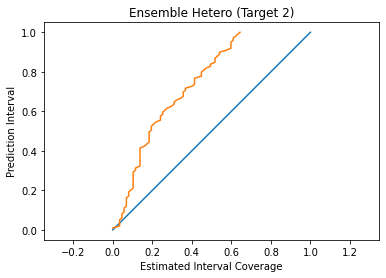

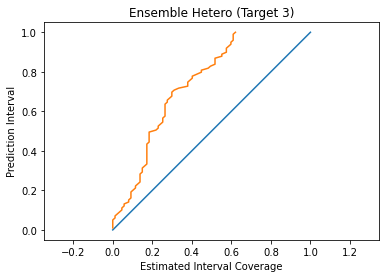

In [491]:
for t in range(args.num_tasks):
    plot_coverage(y_pred[:,t], t, title=f'Ensemble Hetero (Target {t+1})')

In [495]:
y_pred_ens = y_pred
y_std_ens= y_stds

In [496]:
np.sqrt(np.mean((y_pred_ens - y_test)**2))

1.0437514454098147

## Figure used in Report

In [459]:
t = 0 # Target to use

In [460]:
preds = (y_pred_var, y_pred_lv.T,y_pred_ens)
stds = (y_std_var, y_std_lv, y_std_ens)

<Figure size 432x288 with 0 Axes>

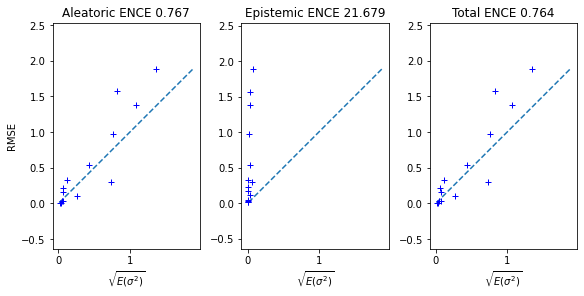

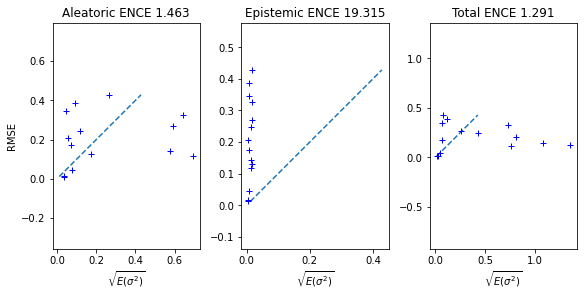

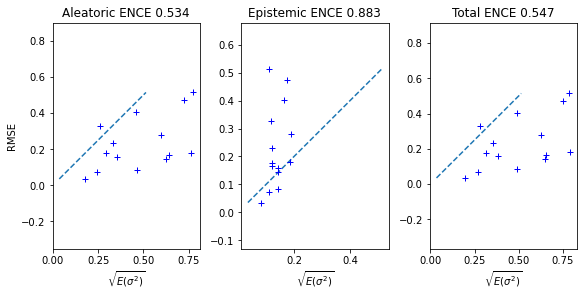

In [461]:
titles = ['Aleatoric', 'Epistemic', 'Total']
names = ['Variational', "Langevin", "Ensemble"]

alignments = [1.75, 1.75, 1.75]

plt.figure()

for i in range(3):
    fig, axs = plt.subplots(1, 3, sharey=False, constrained_layout=True, figsize=(8,4))
    axs[0].set_ylabel('RMSE')
    y_stds = stds[i]
    y_pred = preds[i]
    
    for j, (align, title, y_std) in enumerate(zip(alignments, titles, y_stds)):
        
        if i == 1:
            sigma, rmse, ence = error_calibration(y_pred[:,t], y_std[t,:], t, title='Aleatoric')
        else:
            sigma, rmse, ence = error_calibration(y_pred[:,t], y_std[:,t], t, title='Aleatoric')
            
        x = np.linspace(np.min(rmse),np.max(rmse),100)
        y = x
        #print(t, title, "ENCE: ", ence)
        axs[j].plot(x, y, '--')
        axs[j].plot(sigma, rmse, 'b+')
        axs[j].set_xlabel('$\sqrt{E(\sigma^2)}$')
        axs[j].set_ylim(np.min(rmse), np.max(rmse))
        axs[j].axis('equal')
        axs[j].set_title(f"{title} ENCE {ence:.3f}")
        
plt.show()  
        

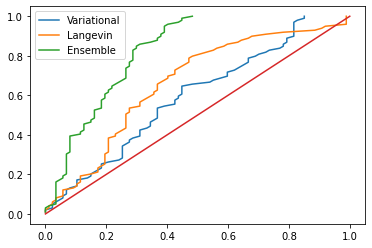

In [463]:
for i in range(args.num_tasks):
    y_pred = preds[i]
    pred_ints = np.linspace(0, 1, 100)[1:]
    y_test = np.array(target_batch)
    icp = []
    for pred_int in pred_ints:
        p_upper = 1 - (1-pred_int)/2
        p_lower = p_upper - pred_int
        q1 = np.quantile(y_pred[:,t], p_lower, axis=0)
        q2 = np.quantile(y_pred[:,t], p_upper, axis=0)

        icp.append(np.mean(np.logical_and(y_test[:,t].squeeze() < q2, y_test[:,t].squeeze() > q1)))
    
    x_perf = np.linspace(0, 1, 1000)
    plt.plot(icp, pred_ints, label = titles[i])

plt.plot(x_perf, x_perf)
plt.legend()
plt.savefig('leo_target1.eps')
plt.show()
    
    